In [488]:
import ete3
import pandas as pd
import re
import multiprocessing
import numpy as np
import itertools
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn import manifold
import networkx as nx
import community
import random
import collections
import operator

%cd /work/kelsey/hgt/

/work/kelsey/hgt


In [2]:
def get_node_age_from_descendants(tree, descendants):
    node = tree.get_common_ancestor(descendants)
    return(node.support)

In [3]:
tree              = ete3.Tree('species_tree')
ranger_named_tree = ete3.Tree('species_tree_named_nodes', format=1)

genomes           = pd.read_csv('../genomes.tab', sep='\t', index_col=0)
genomes.Organism  = genomes.Organism.replace('\s+\(.+\)$', '', regex=True)

transfer_df       = pd.read_csv('transfers-filtered_by_confidence.tab', sep='\t', index_col=0)

name_conversion = {}
for index, row in genomes.iterrows():
    if index.startswith('GC'):
        name_conversion[row.abbreviation] = re.sub('\.\d+$', '', index, flags=re.M).replace('_', '')
    else:
        name_conversion[row.abbreviation] = row.accession.replace('_', '')

for leaf in tree.get_leaves():
    if leaf.name in name_conversion:
        leaf.add_feature('accession', name_conversion[leaf.name])
    else:
        leaf.add_feature('accession', leaf.name.replace('_', ''))

In [4]:
name_table = pd.DataFrame(columns=['name', 'accession'],
                          data=[(leaf.name, leaf.accession) for leaf in tree.get_leaves()])

for node in ranger_named_tree.traverse():
    if node.is_leaf():
        continue

    descendants     = name_table.loc[name_table.accession.isin(node.get_leaf_names()),
                                     'name'].values.tolist()
    equivalent      = tree.get_common_ancestor(descendants)
    equivalent.name = node.name

In [5]:
posterior_trees = [ete3.Tree(line)
                   for line in open('Cyano_modelBB_long_ugam_bd_7_20_sample.datedist').readlines()]

In [6]:
constraints = list(
    transfer_df.groupby(['donor', 'recipient']).groups.keys()
)

In [7]:
def assess_constraint_compatibility(constraint):
    older_bound   = next(tree.iter_search_nodes(name=constraint[0]))
    younger_bound = next(tree.iter_search_nodes(name=constraint[1]))
    
    compatibilities = []
    for tmp_tree in posterior_trees:
        older_bound_age   = get_node_age_from_descendants(tmp_tree,   older_bound.get_leaf_names())
        younger_bound_age = get_node_age_from_descendants(tmp_tree, younger_bound.get_leaf_names())
        
        if older_bound_age > younger_bound_age:
            compatibilities.append(True)
        else:
            compatibilities.append(False)

    return(compatibilities)

In [10]:
pool    = multiprocessing.Pool(processes=20)
results = pool.map(assess_constraint_compatibility, constraints)

compatibility_table = pd.DataFrame(columns=constraints,
                                   data   =np.array(results).T)

compatibility_count      = compatibility_table.sum()
compatibility_count.name = 'compatibility_count'

In [35]:
def jaccard_between_constraints(constraints):
    intersection = sum(compatibility_table[constraints].T.all())
    union        = sum(compatibility_table[constraints].T.any())
    
    if not union:
        return(0.0)
    else:
        return(intersection/union)

In [39]:
pairs_of_constraints = [list(pair) for pair in itertools.combinations(constraints, 2)]

In [44]:
pool                = multiprocessing.Pool(processes=20)
condensed_distances = np.array(
    pool.map(jaccard_between_constraints, pairs_of_constraints)
)

jaccard_distances = pd.DataFrame(index=constraints,
                                 columns=constraints,
                                 data=squareform(condensed_distances))

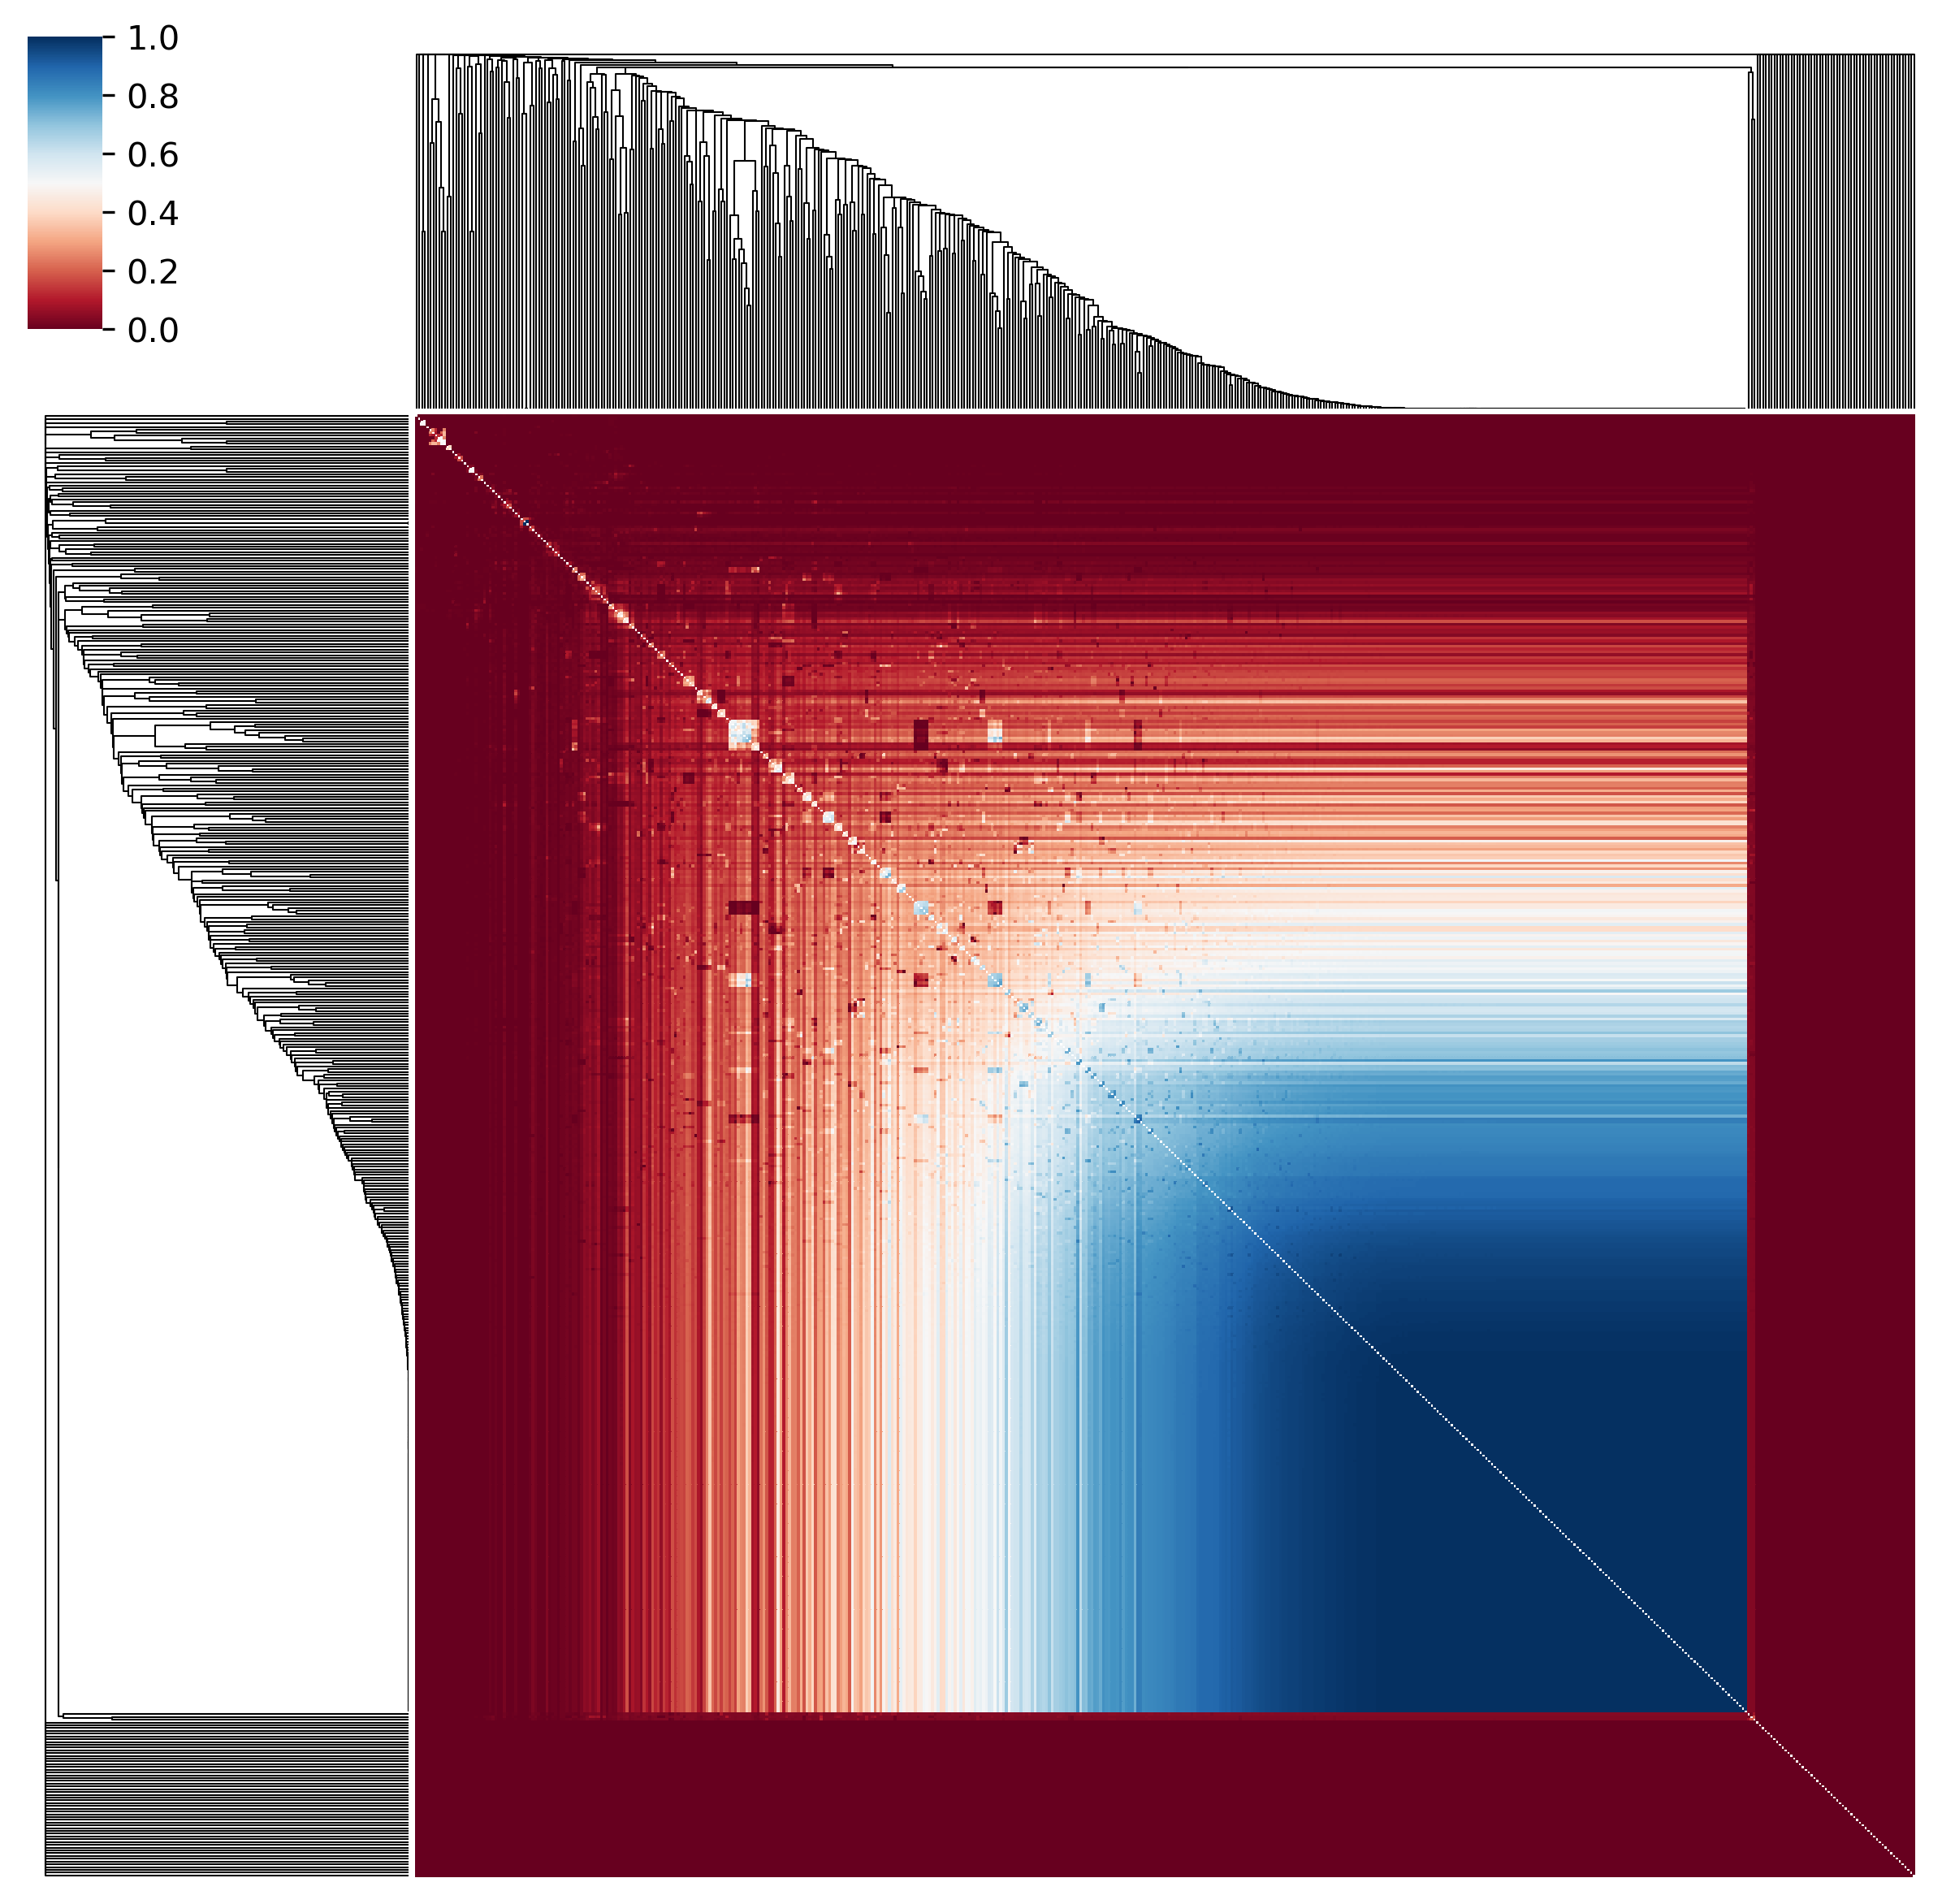

In [465]:
linkage = hierarchy.linkage(1-condensed_distances, method='average', metric='precomputed')

tmp_df = jaccard_distances.copy()
np.fill_diagonal(tmp_df.values, np.nan)

clst_map = sns.clustermap(tmp_df,
                          row_linkage=linkage,
                          col_linkage=linkage,
                          cmap='RdBu',
                          yticklabels=False,
                          xticklabels=False);
clst_map.fig.set_dpi(300)

In [734]:
tmp_df = 1-jaccard_distances
np.fill_diagonal(tmp_df.values, 0)

mds = manifold.MDS(n_components=2,
                   dissimilarity='precomputed',
                   random_state=12345)
mds_result = mds.fit(tmp_df)

coords     = mds_result.embedding_
constraintX, constraintY = coords[:, 0], coords[:, 1]

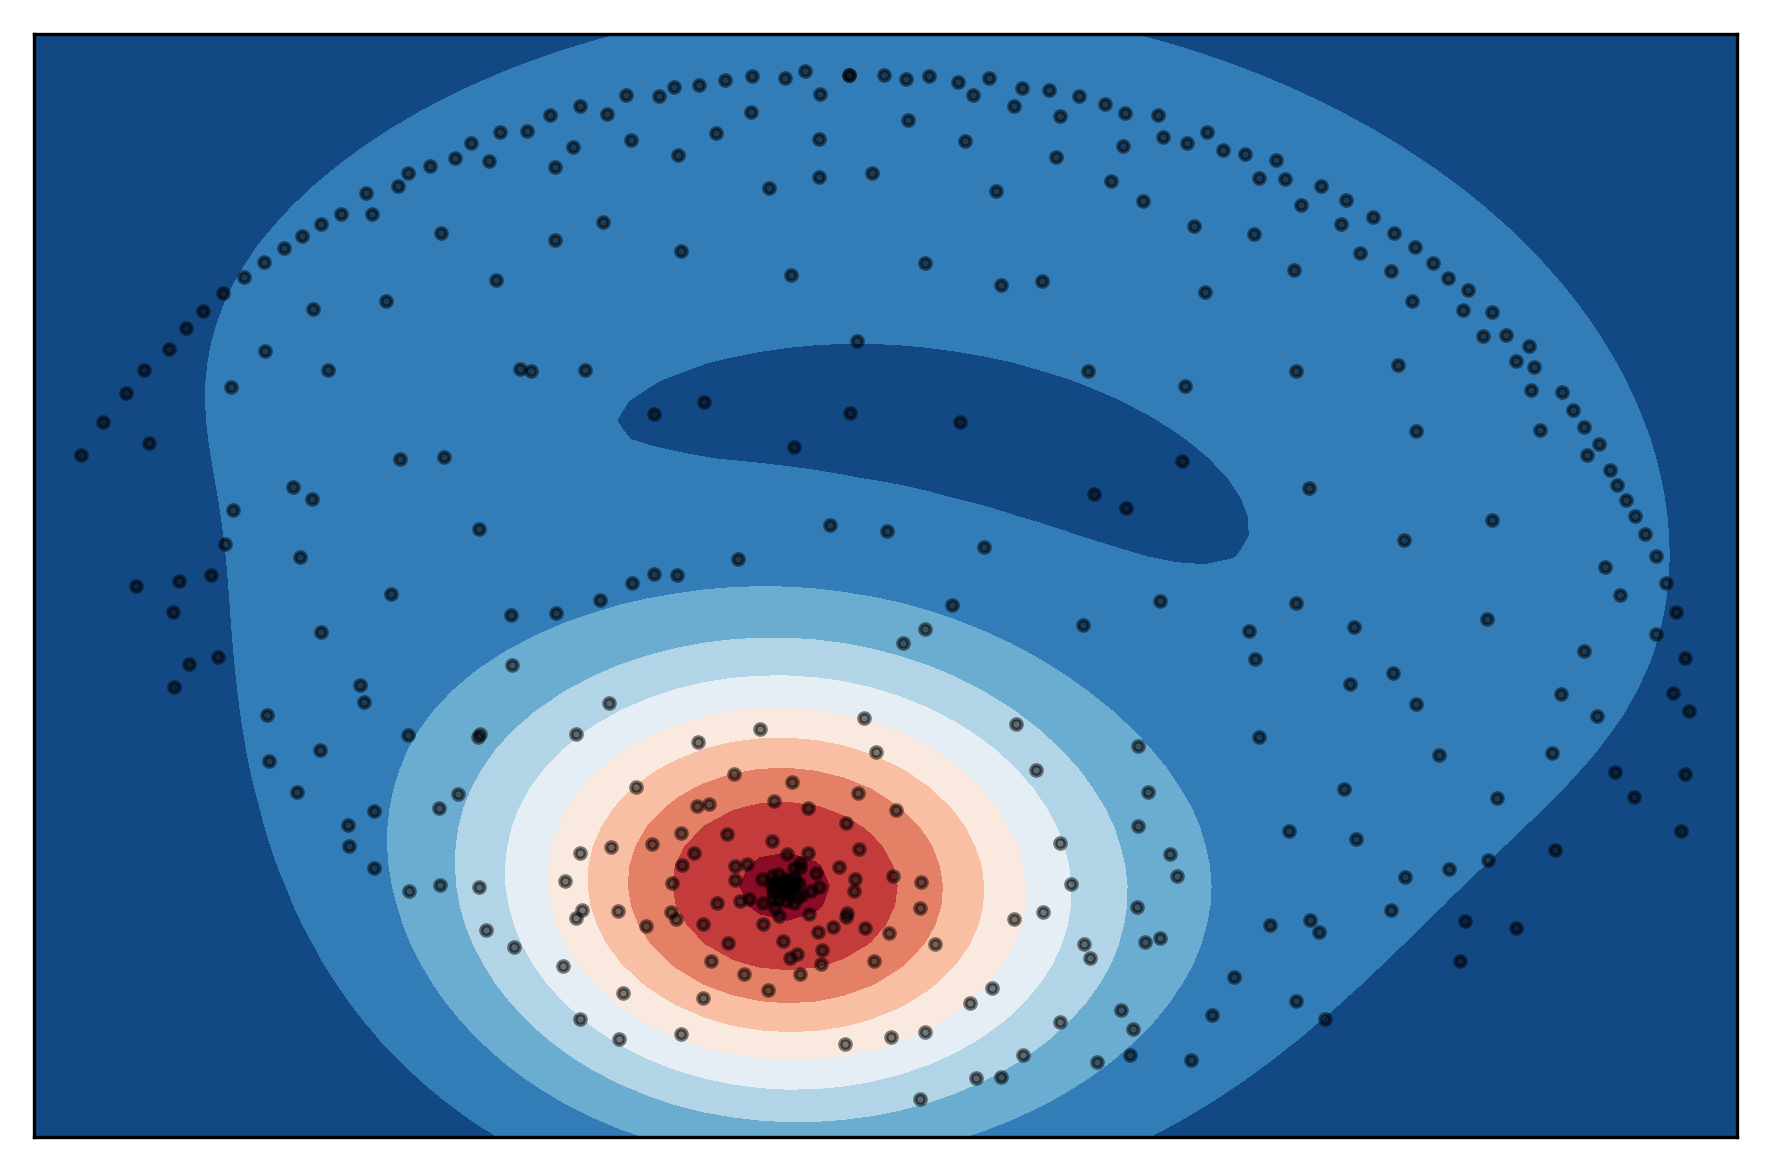

In [466]:
fig, ax = plt.subplots()

sns.kdeplot(x, y,
            bw=0.2,
            n_levels=9,
            cmap='RdBu_r',
            shade=True,
#            shade_lowest=False,
            ax=ax)

#sns.scatterplot(x, y,
#                hue=jaccard_distances.sum().values,
#                palette='RdBu',
#                alpha=0.5,
#                legend=False,
#                ax=ax);
ax.plot(x, y,
        '.k', 
        alpha=0.5, 
        markersize=5)

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)
#ax.axis('equal')
ax.set_xlim(x.min()-0.05, x.max()+0.05)
ax.set_ylim(y.min()-0.05, y.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

In [892]:
tmp_df         = jaccard_distances.copy()
tmp_df.index   = range(526)
tmp_df.columns = range(526)

In [893]:
graph   = nx.convert_matrix.from_pandas_adjacency(tmp_df)
louvain = community.best_partition(graph, random_state=12345)

In [894]:
clusters = []
for count, constraint in enumerate(constraints):
    clusters.append(louvain[count])

cluster_frequencies     = dict(collections.Counter(clusters))
clusters_sorted_by_size = sorted(cluster_frequencies.items(), key=operator.itemgetter(1), reverse=True)

In [794]:
cluster_coords                 = pd.DataFrame(columns='x y cluster'.split(), 
                                              data=zip(constraintX,constraintY, clusters))
cluster_coords['cluster_size'] = [cluster_frequencies[cluster]
                                  for cluster in cluster_coords.cluster]
cluster_coords.loc[cluster_coords.cluster_size<3, 'cluster'] = 'none'

cluster_coords.index = constraints
cluster_coords       = cluster_coords.join(compatibility_count)

constraint_supports = {constraint:len(indexes)
                       for constraint, indexes in transfer_df.groupby(['donor', 'recipient']).groups.items()}
cluster_coords      = cluster_coords.join(
    pd.DataFrame.from_dict([constraint_supports]).T
)
cluster_coords.rename(columns={0:'constraint_support'}, inplace=True)

constraint_distance = [tree.get_distance(node1, node2)
                      for node1, node2 in cluster_coords.index]
cluster_coords['constraint_distance'] = constraint_distance

In [899]:
cluster_coords.to_csv('constraint_clusters-BB.tab', sep='\t')

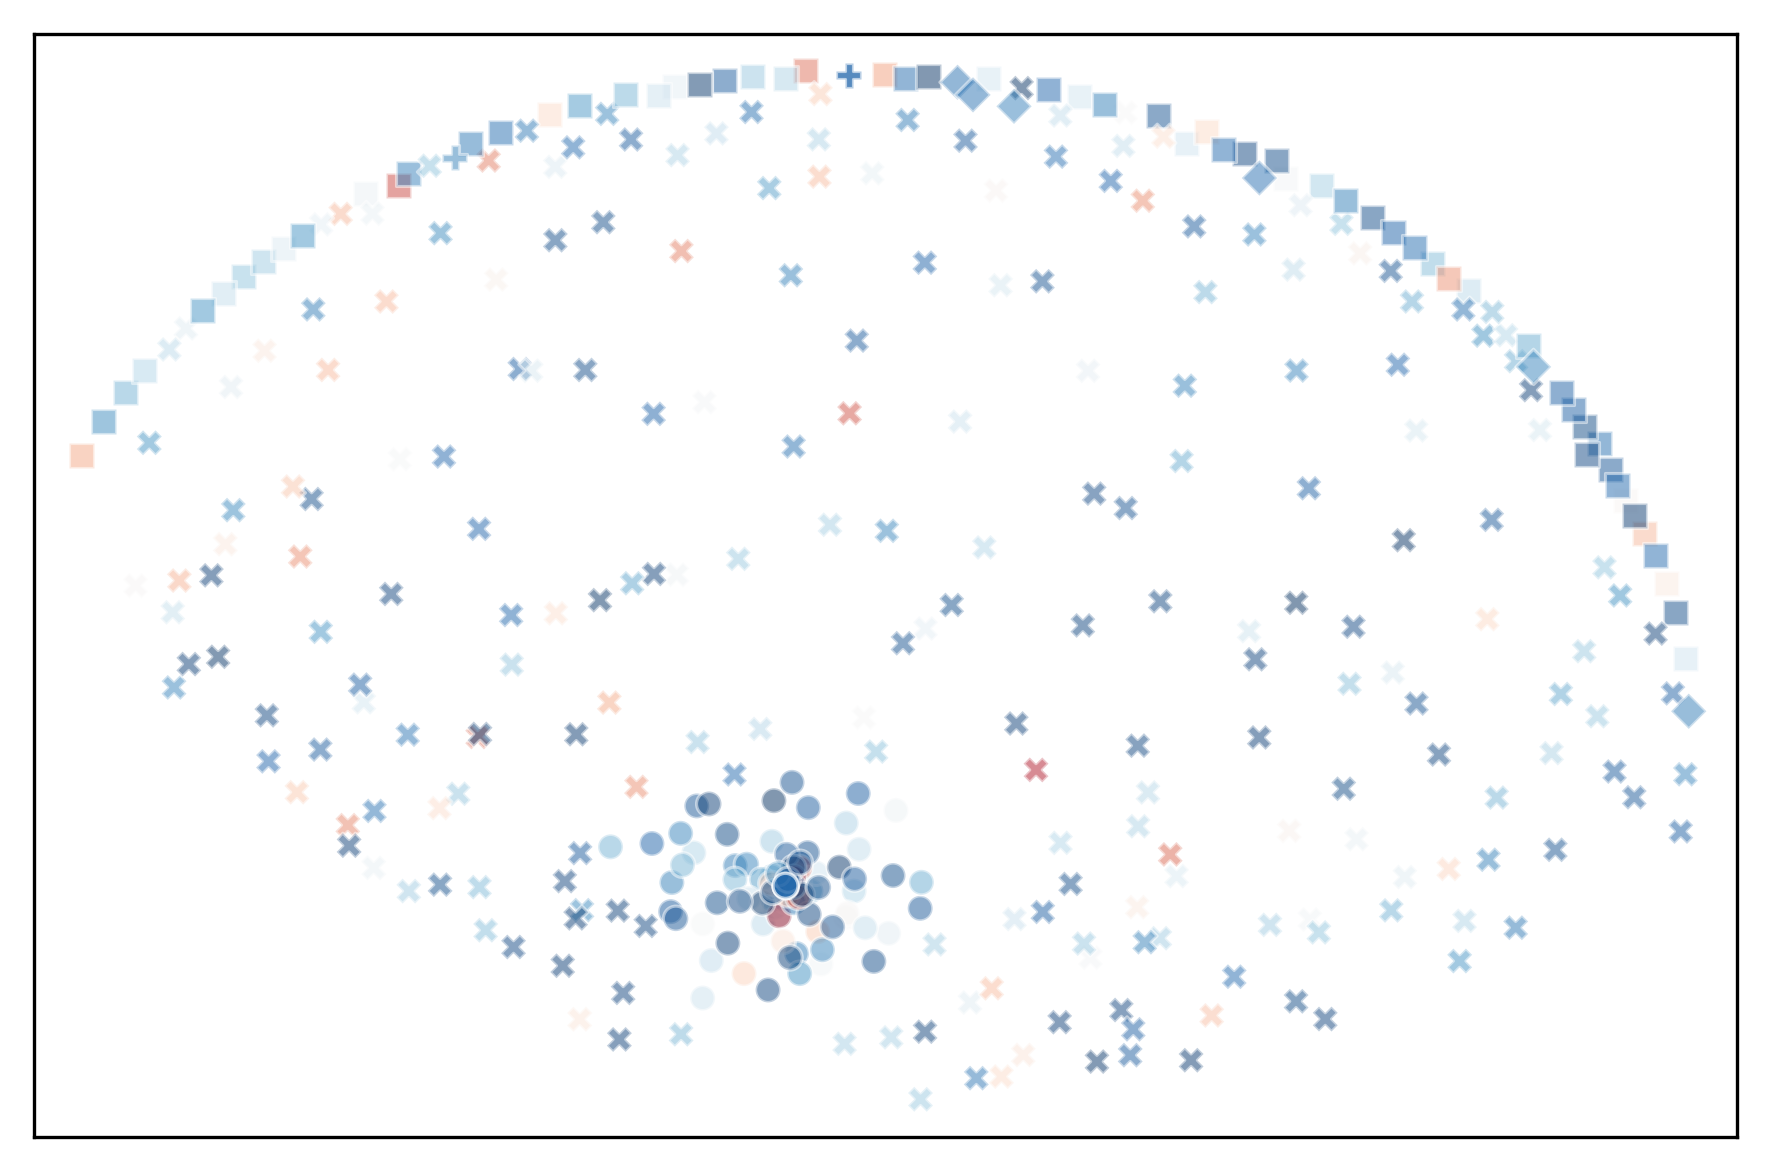

In [889]:
fig, ax = plt.subplots()

yeah = sns.scatterplot(x='x', 
                y='y',
                style='cluster',
                hue='constraint_distance',
                palette='RdBu_r',
                data=cluster_coords,
                alpha=0.5,
#                size='compatibility_count',
#                color='black',
                legend=False,
                ax=ax,
                      cmap=plt.cm.get_cmap('cubehelix', 6));

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)

#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

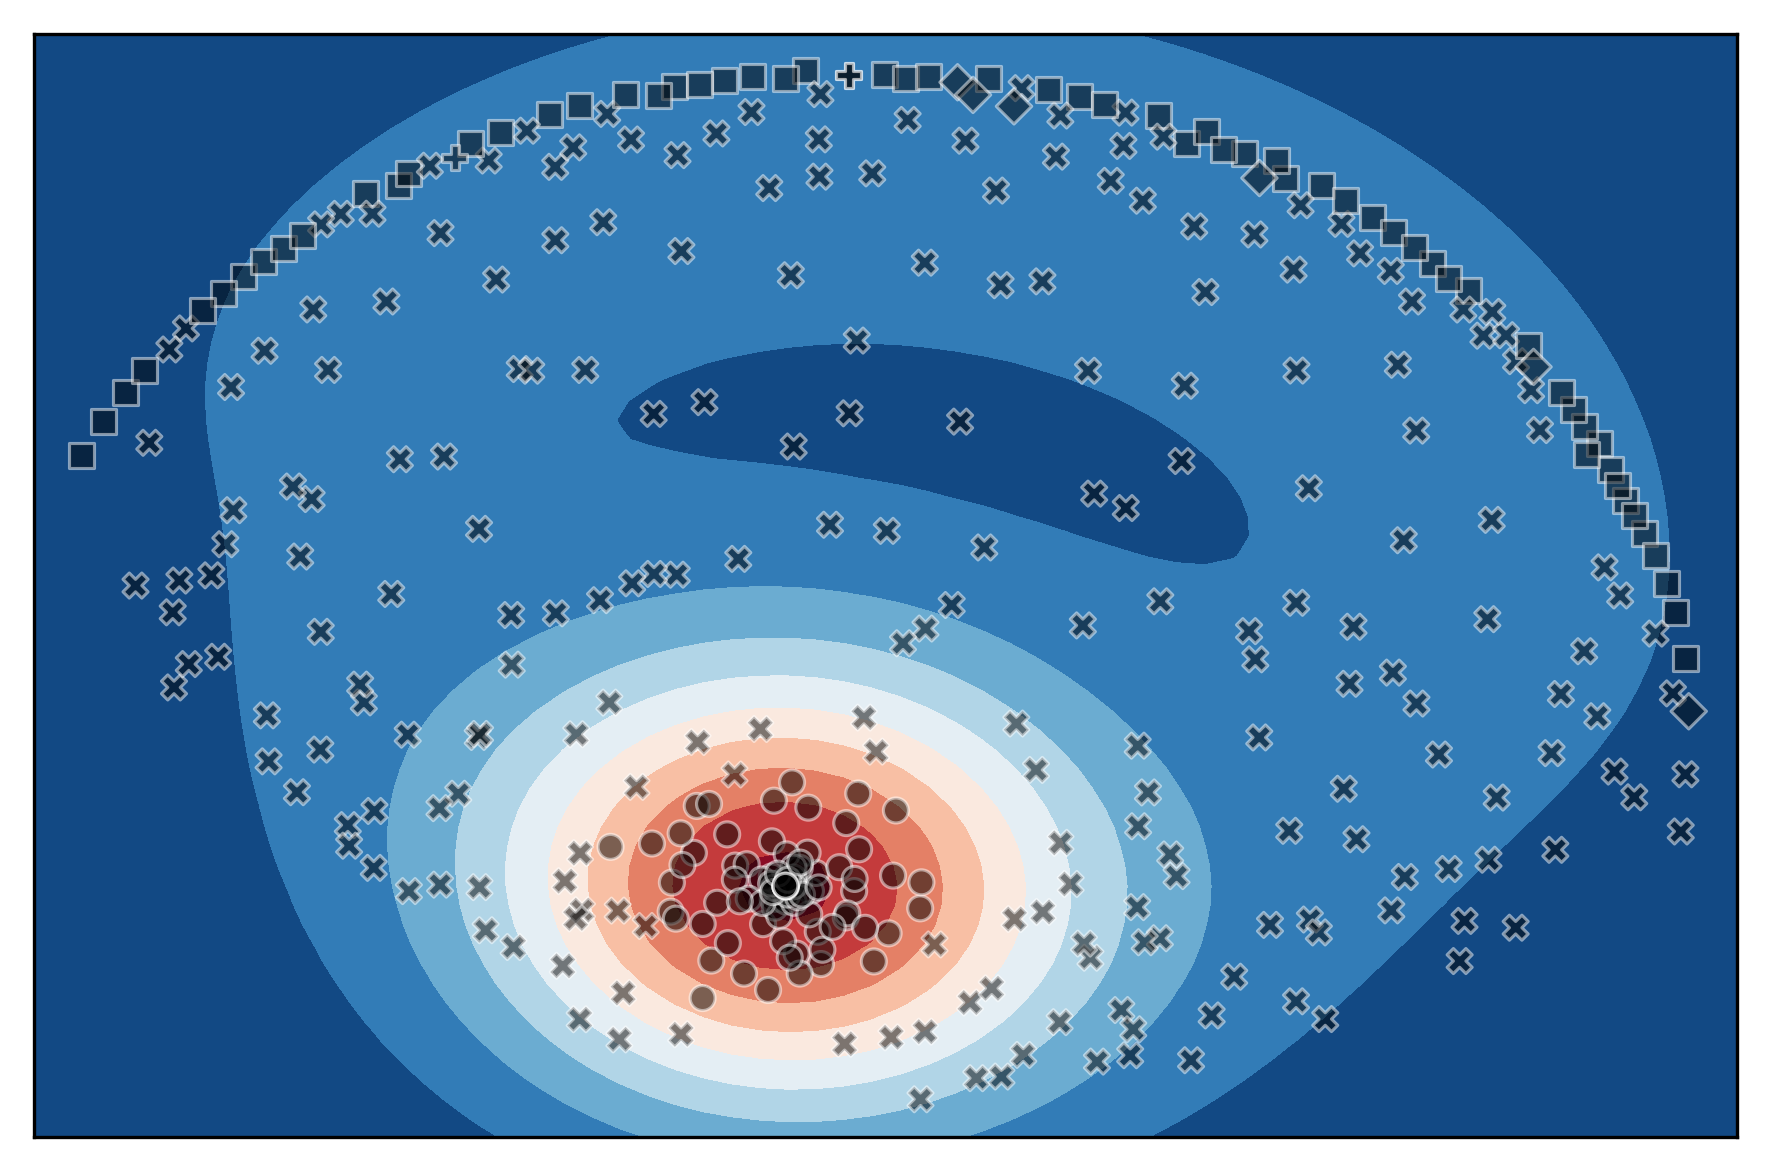

In [819]:
fig, ax = plt.subplots()

sns.kdeplot(constraintX, 
            constraintY,
            bw=0.2,
            n_levels=9,
            cmap='RdBu_r',
            shade=True,
            ax=ax,
           )

sns.scatterplot(x='x', 
                y='y',
                style='cluster',
#                hue='constraint_distance',
#                palette='RdBu_r',
                data=cluster_coords,
                alpha=0.5,
#                size='compatibility_count',
                color='black',
                legend=False,
                ax=ax);

ax.tick_params(axis='both',
               which='both',
               bottom=False,
               labelbottom=False,
               left=False,
               labelleft=False)
#ax.axis('equal')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(constraintX.min()-0.05, constraintX.max()+0.05)
ax.set_ylim(constraintY.min()-0.05, constraintY.max()+0.05)
fig.set_dpi(300)
fig.tight_layout()

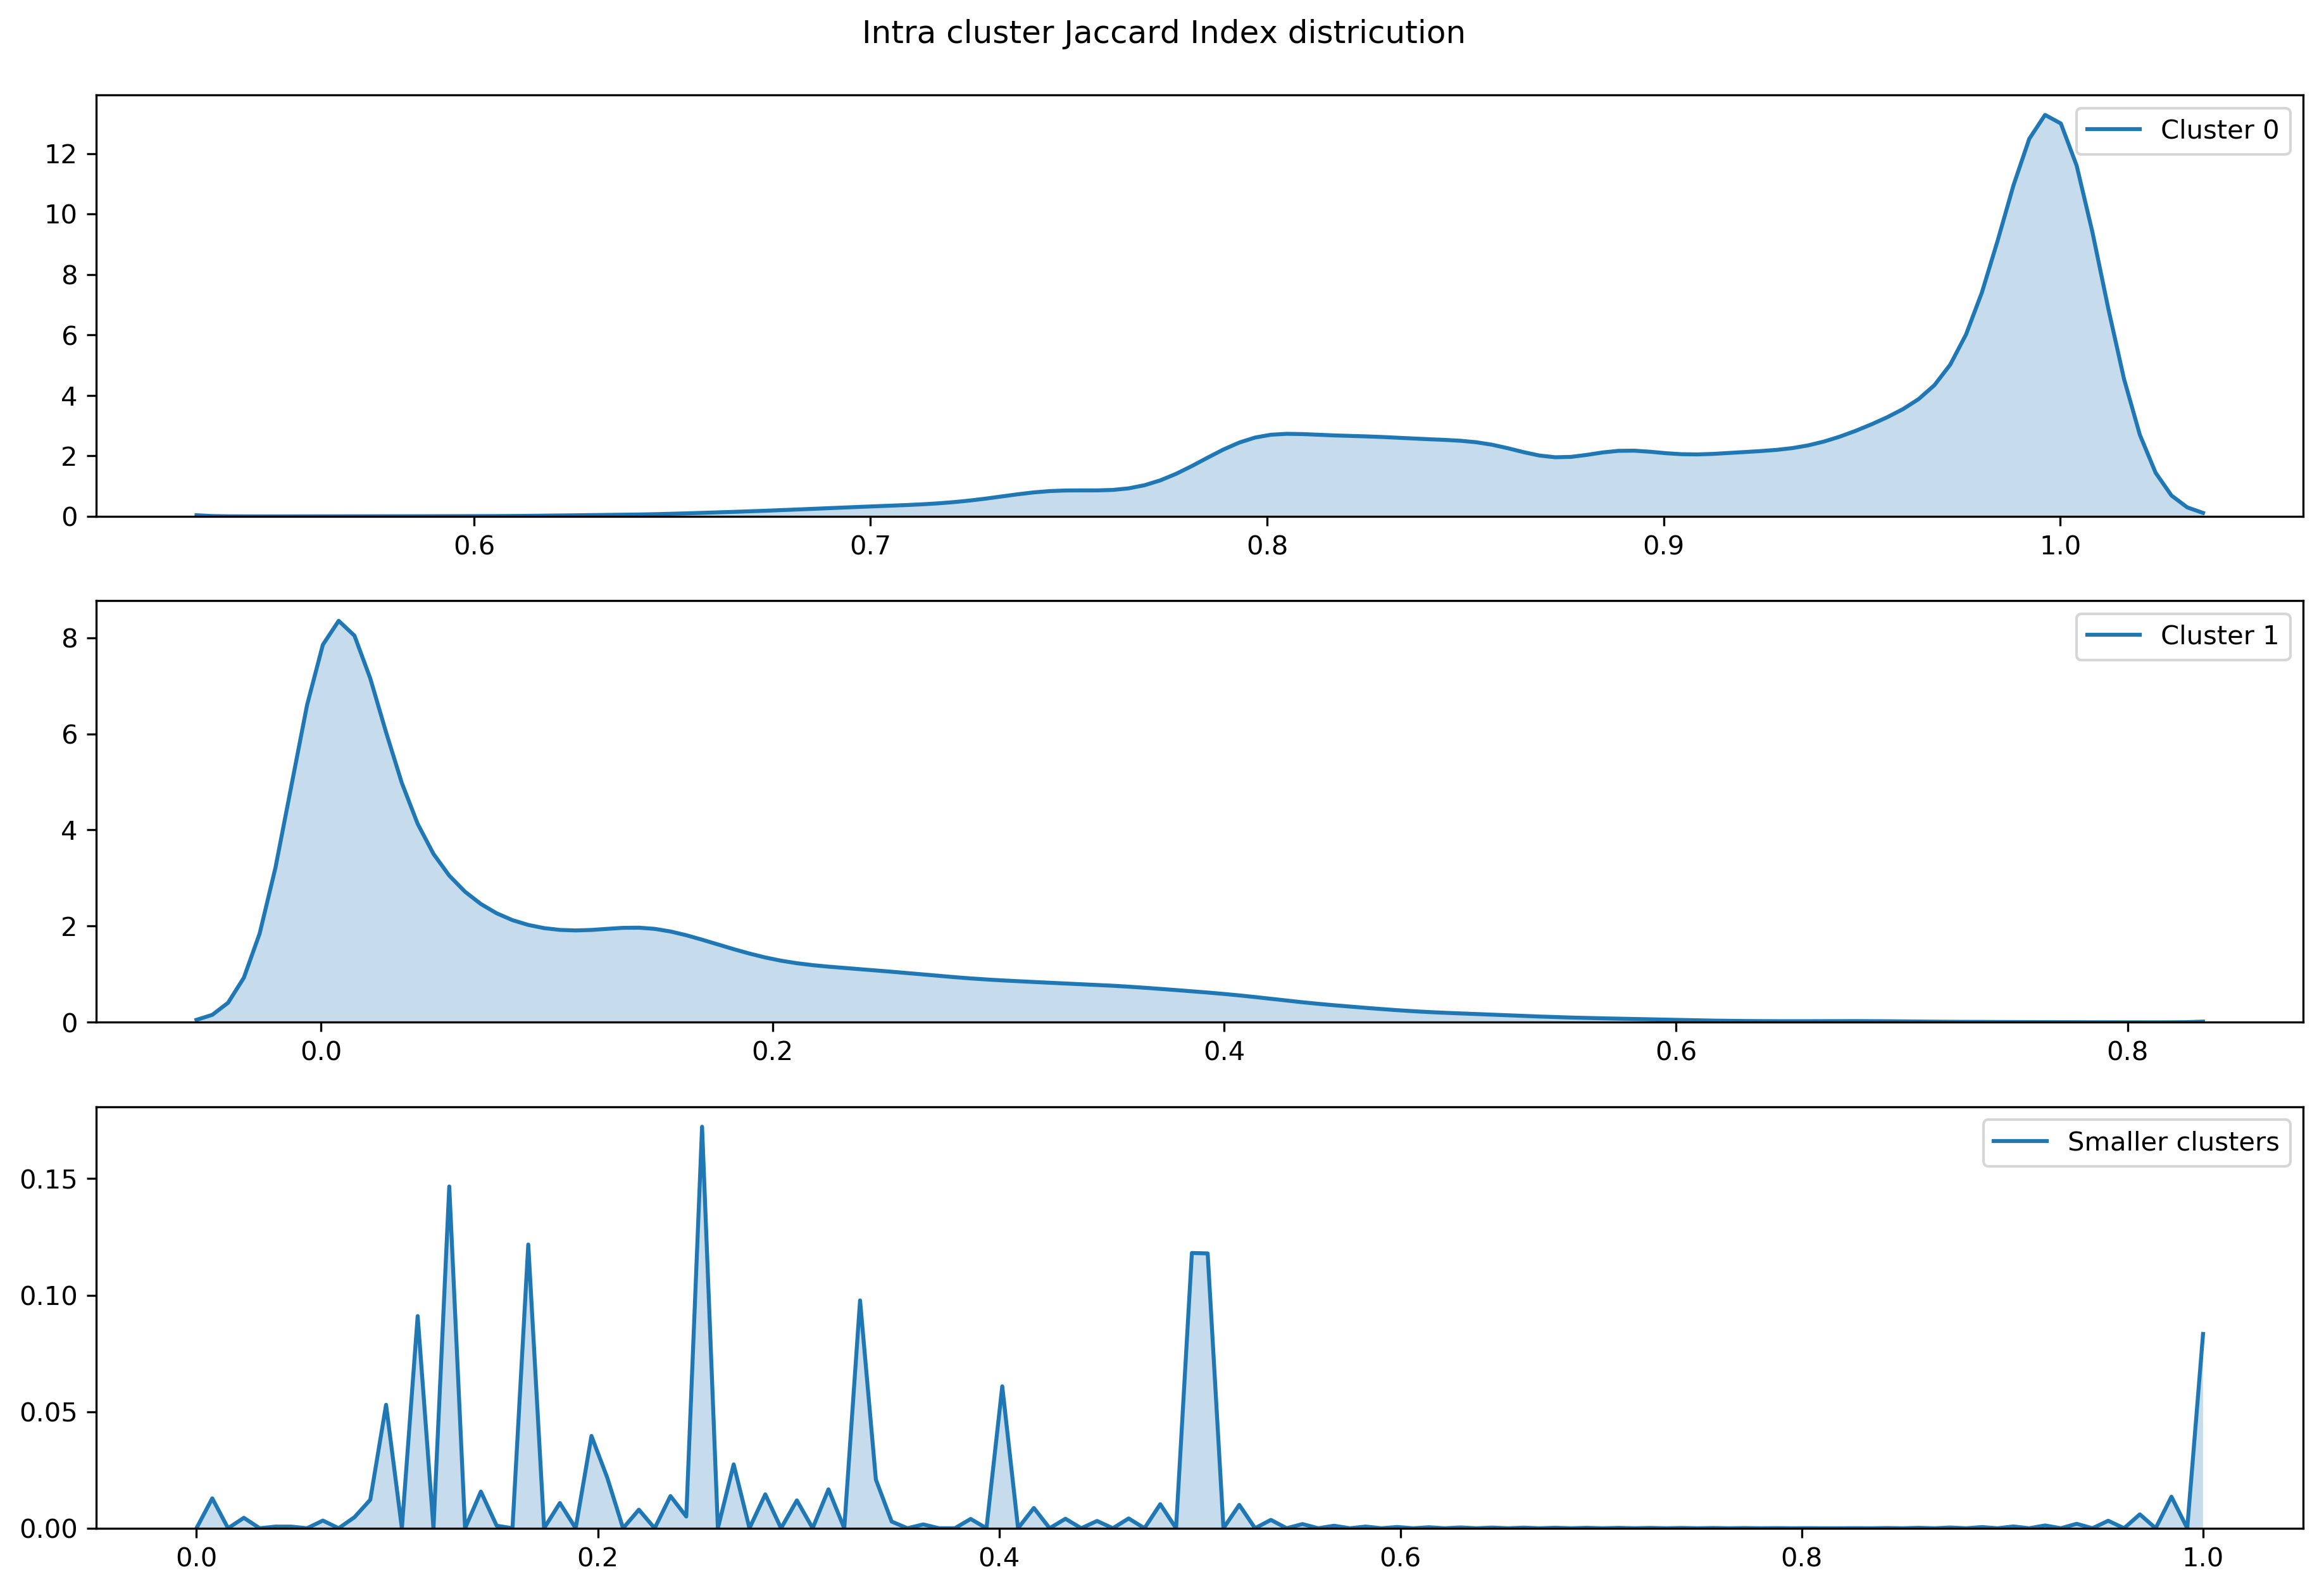

In [605]:
fig, axs = plt.subplots(nrows=3, figsize=(15,10))
for cluster_num, ax in zip([0, 1], axs):
    tmp = cluster_coords.index[cluster_coords.cluster==cluster_num]
    tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
    sns.kdeplot(tmp_condensed, shade=True, ax=ax, label='Cluster %i' % cluster_num)

tmp           = cluster_coords.index[(cluster_coords.cluster!=0) &
                                     (cluster_coords.cluster!=1)]
tmp_condensed = squareform(jaccard_distances.reindex(index=tmp, columns=tmp))
sns.kdeplot(tmp_condensed, shade=True, ax=axs[2], label='Smaller clusters')
fig.suptitle('Intra cluster Jaccard Index districution', y=0.92)
fig.set_dpi(300)

In [898]:
cluster_coords.head()

,x,y,cluster,cluster_size,compatibility_count,constraint_support,constraint_distance
"(n100, n106)",-0.083405,-0.277083,0,228,9893,1,0.135828
"(n100, n108)",-0.083164,-0.277383,0,228,9900,1,0.184166
"(n100, n114)",-0.056508,-0.284215,0,228,9453,1,0.684998
"(n100, n56)",-0.083164,-0.277383,0,228,9900,1,0.440491
"(n100, n71)",0.228156,0.072427,1,227,4166,1,0.198205


In [897]:
cluster0_coords.head()

,x,y,cluster,cluster_size,compatibility_count,constraint_support,constraint_distance
"(n153, n43)",-0.074736,-0.266254,0,228,9656,1,2.421620
"(n114, n168)",-0.083202,-0.267861,0,228,9733,1,2.336984
"(n137, n43)",-0.089754,-0.317725,0,228,9261,3,2.321203
"(n77, n168)",-0.069981,-0.292699,0,228,9548,1,2.002586
"(n144, n113)",-0.083164,-0.277383,0,228,9900,1,1.997479


In [687]:
cluster0               = set(cluster_coords.query('cluster==0').index.tolist())
cluster0_compatibility = compatibility_table[cluster0]

num_trees, num_constraints = cluster0_compatibility.shape
num_compatibles            = cluster0_compatibility.T.sum()

x = np.linspace(200, num_constraints, 10)
y = []
target_node_ages = {'n8':[],
                    'n117':[],
                    'n159':[]}
target_node_descendants = {}
for node_name in target_node_ages:
    node = next(tree.iter_search_nodes(name=node_name))
    target_node_descendants[node_name] = node.get_leaf_names()

for thresh in x:
    compatible_trees = num_compatibles[num_compatibles >= thresh].index
    y.append(len(compatible_trees)/num_trees)

    for target_node in target_node_ages.keys():
        target_node_ages[target_node].append([])
    
    for tree_index, target_node in itertools.product(compatible_trees, target_node_ages.keys()):
        target_node_ages[target_node][-1].append(
            get_node_age_from_descendants(
                posterior_trees[tree_index],
                target_node_descendants[target_node]
            )
        )
y = np.array(y)

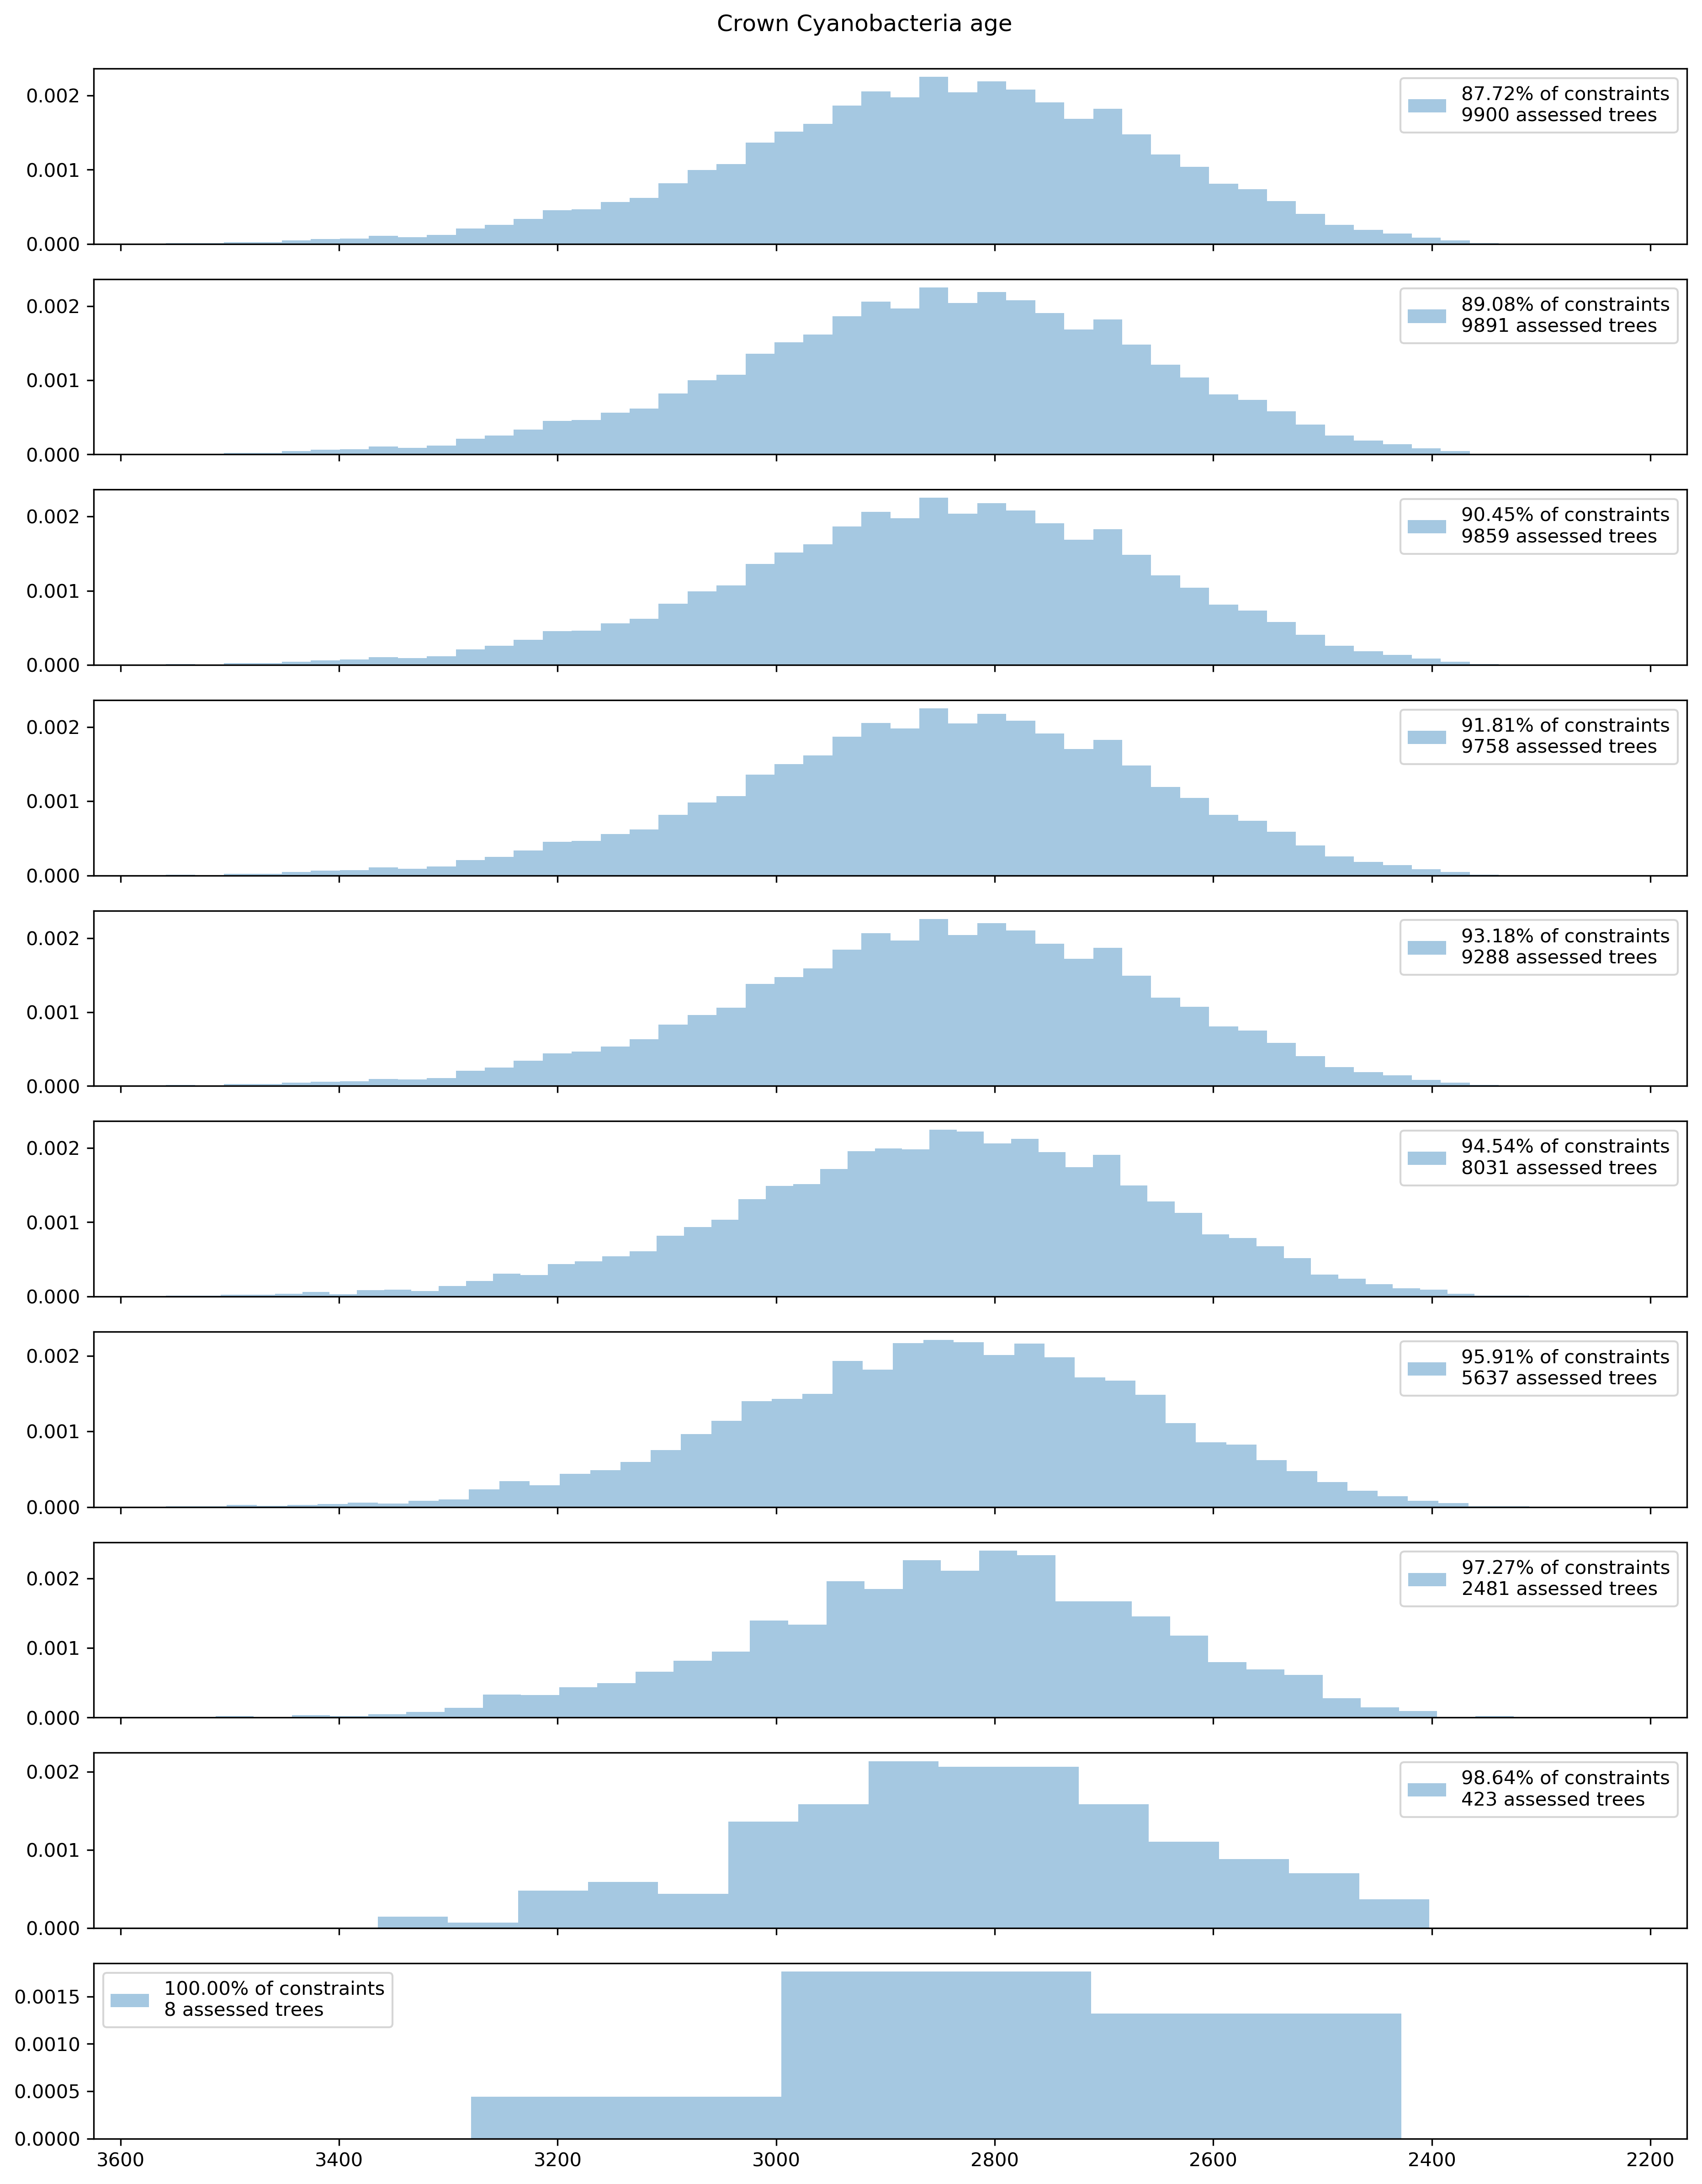

In [724]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n8']),
                        sharex=True)

fig.suptitle('Crown Cyanobacteria age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n8'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.legend()
ax.invert_xaxis()

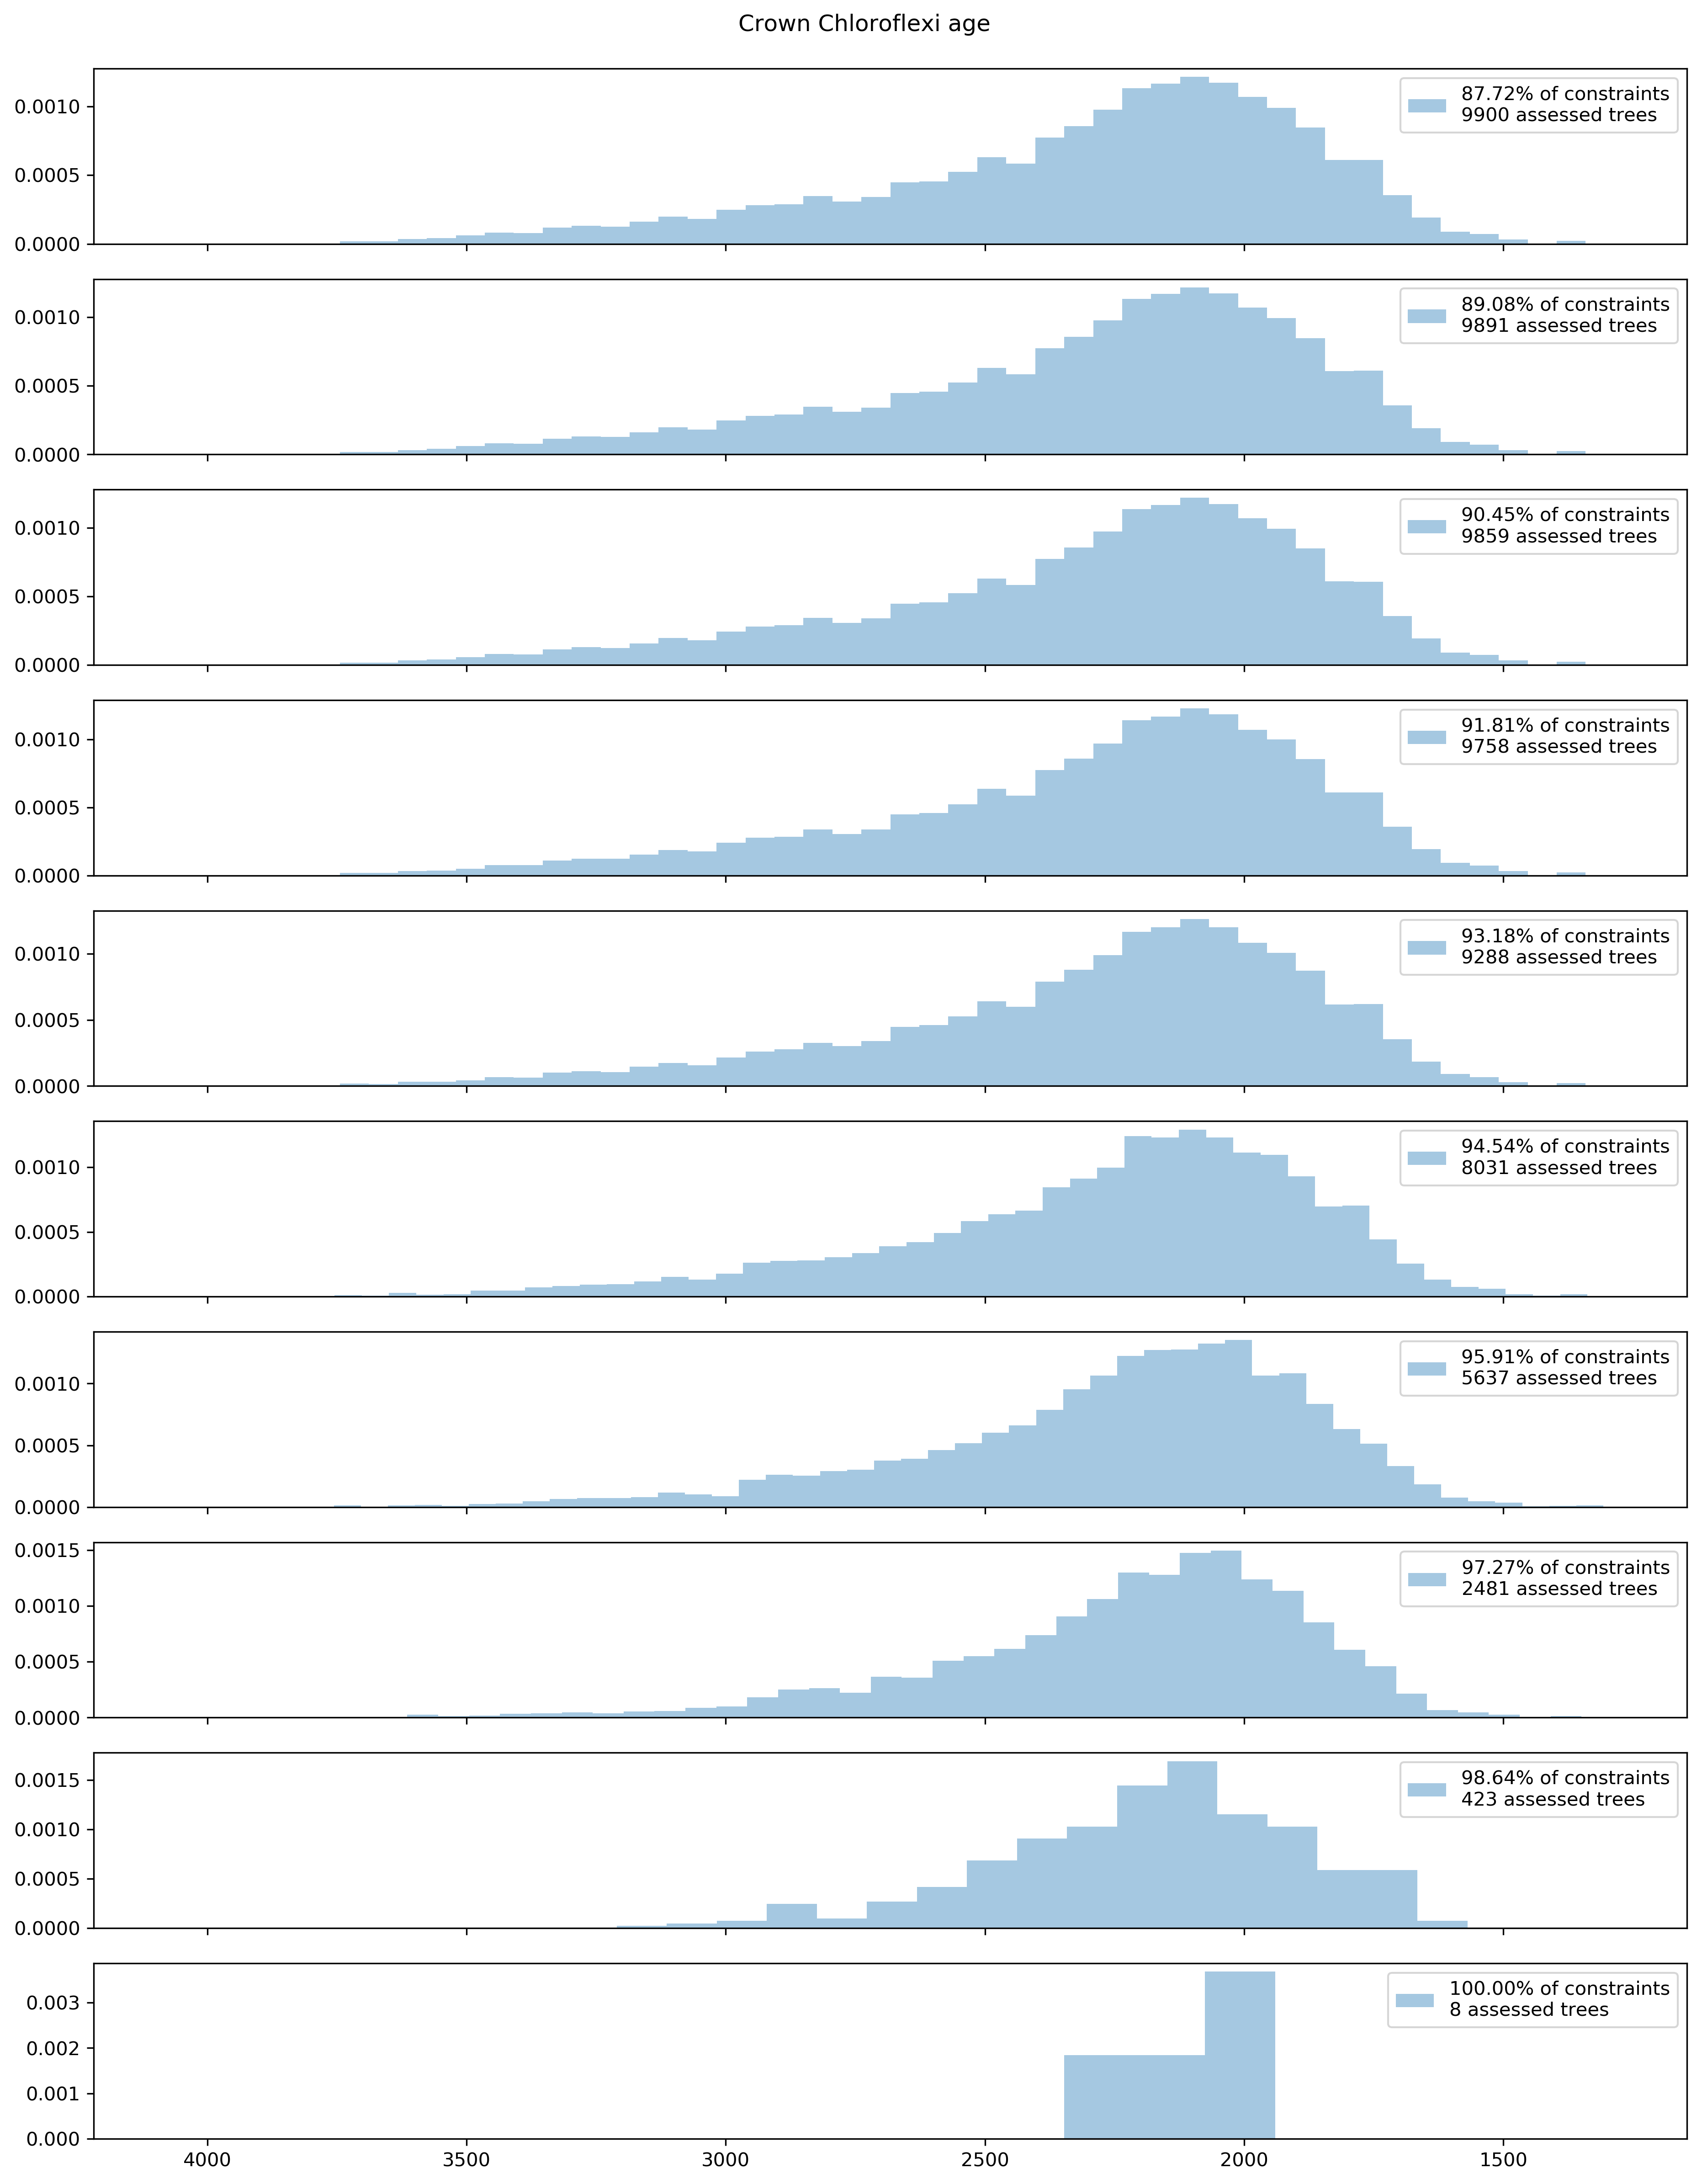

In [725]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n117']),
                        sharex=True)

fig.suptitle('Crown Chloroflexi age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n117'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                 ax=ax)
    ax.legend()
ax.invert_xaxis()

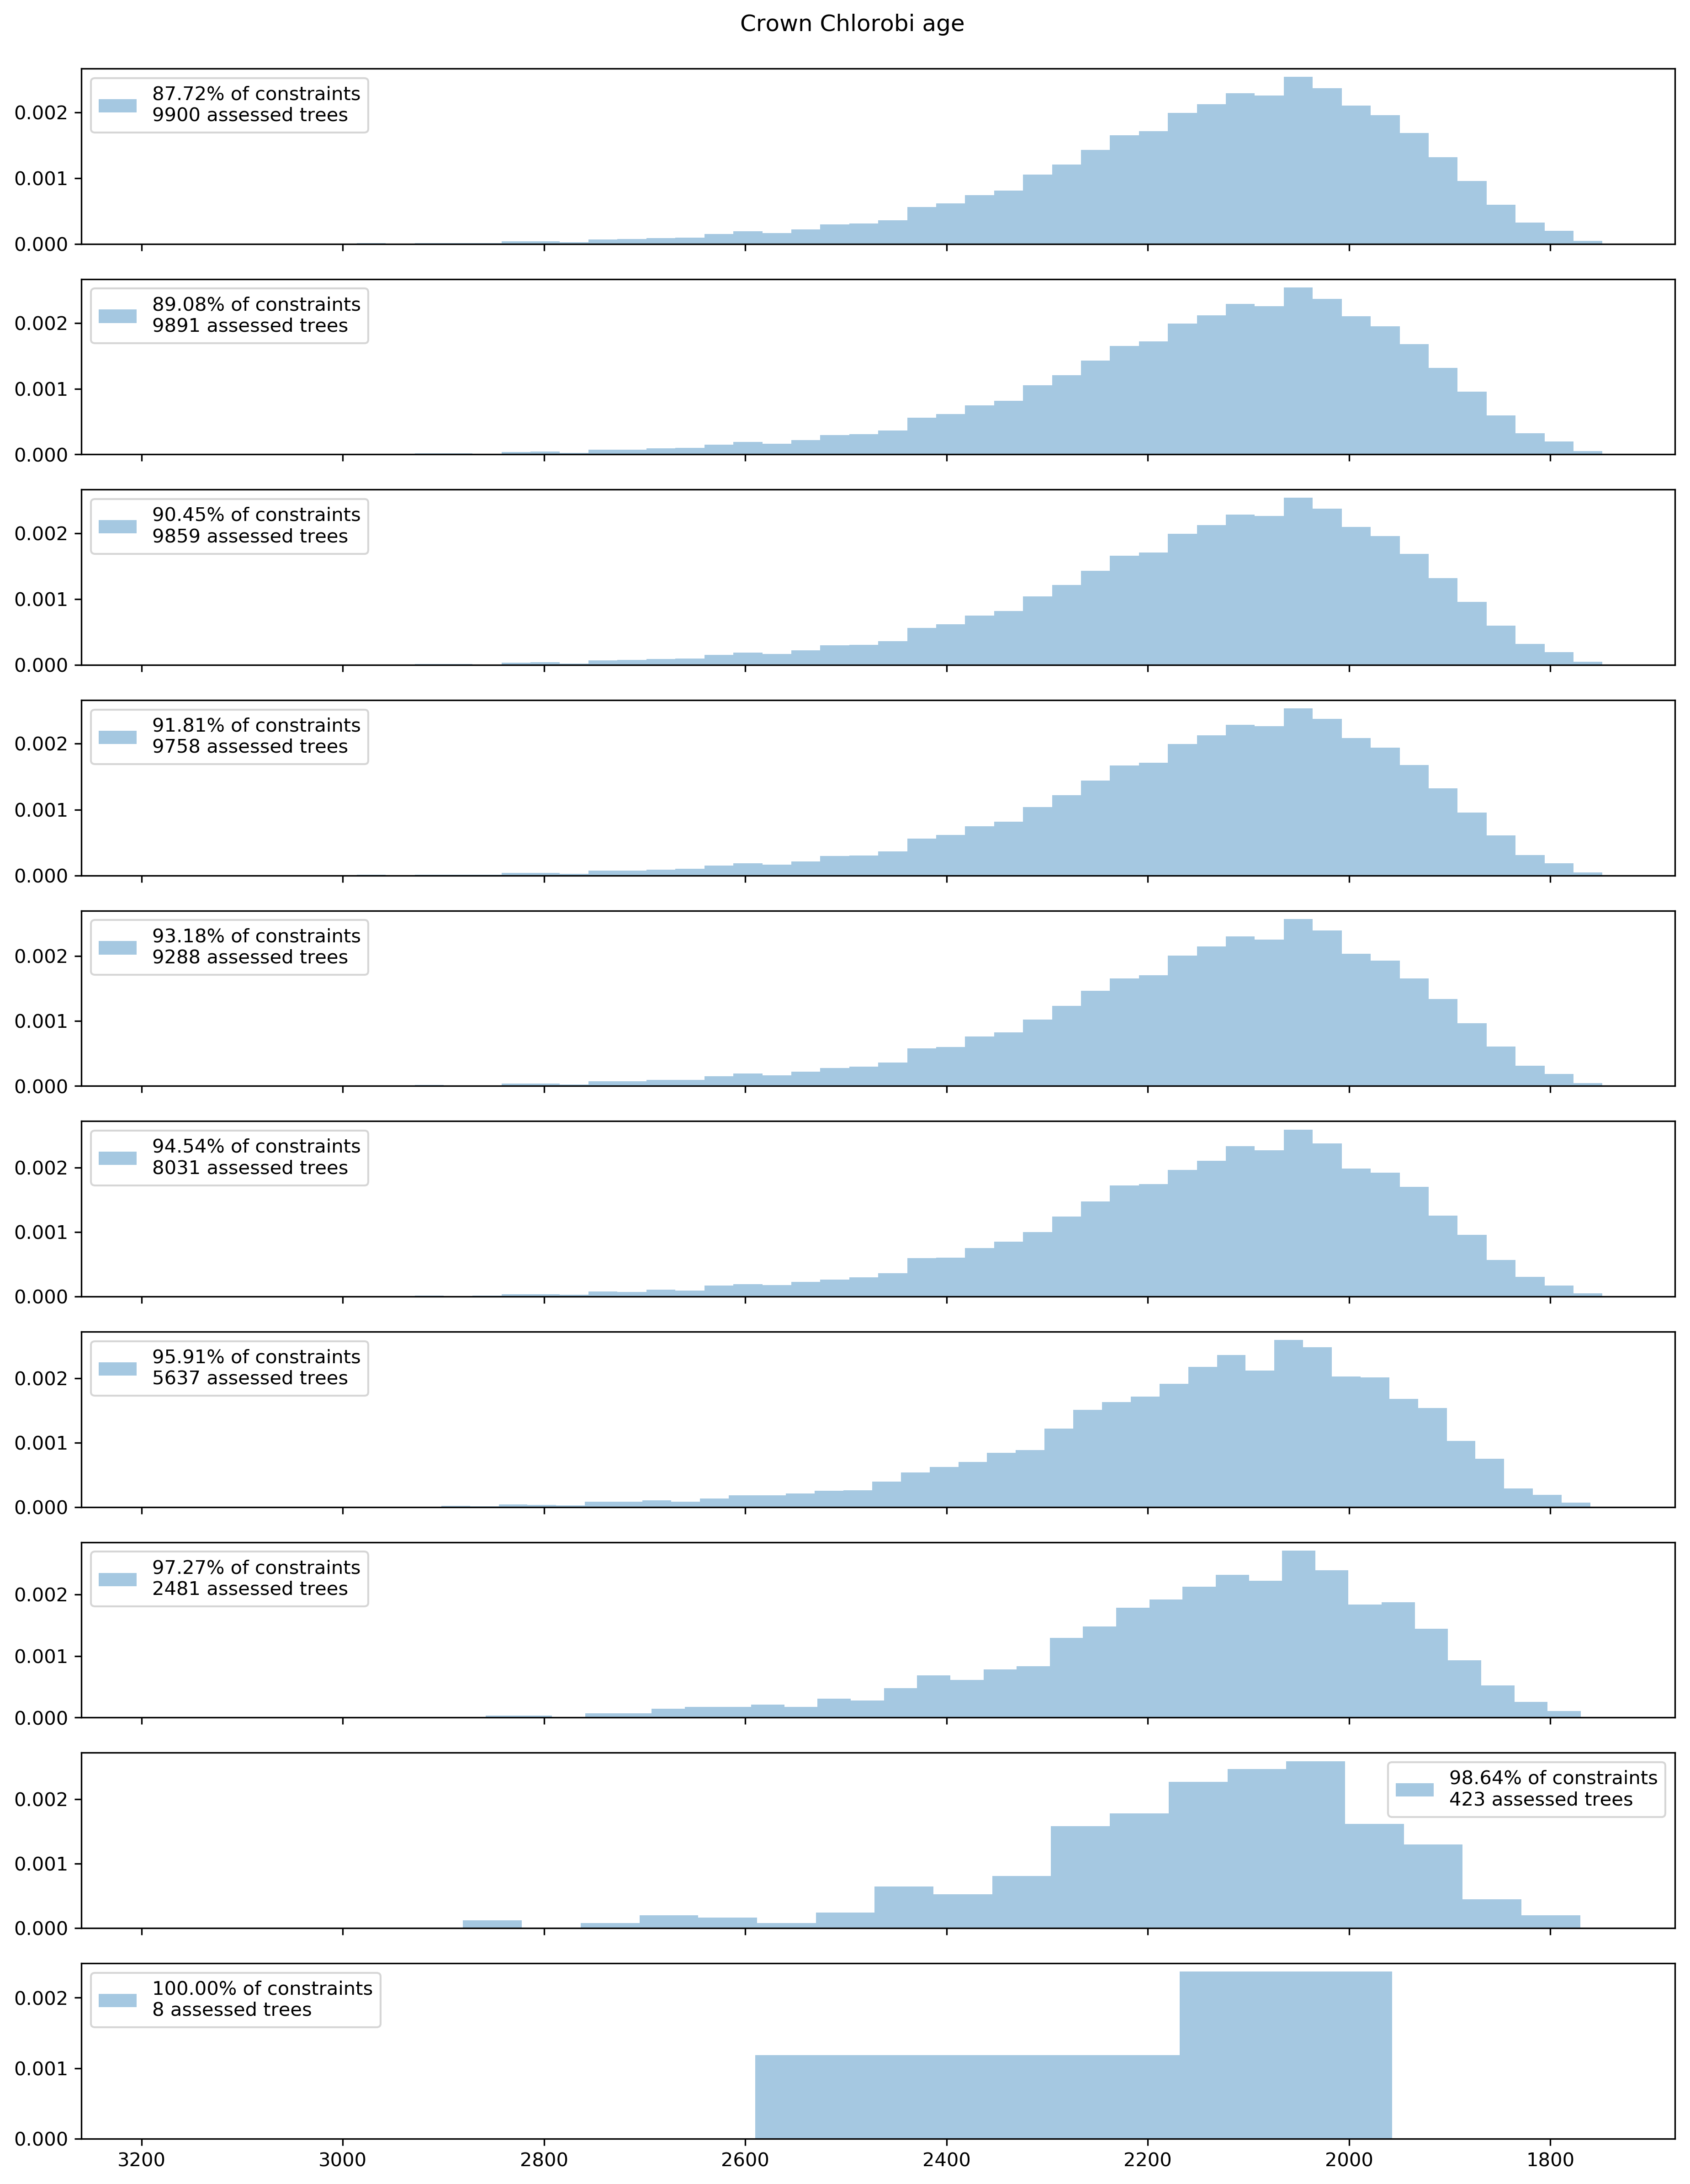

In [723]:
fig, axs = plt.subplots(figsize=(15,20),
                        dpi=300,
                        nrows=len(target_node_ages['n159']),
                        sharex=True)

fig.suptitle('Crown Chlorobi age', y=0.9)

for node_ages, thresh, ax in zip(target_node_ages['n159'], x, axs):
    sns.distplot(node_ages, kde=False,
#                shade=True,
                 norm_hist=True,
                 label='%.2f%% of constraints\n%i assessed trees' % \
                 ((thresh/num_constraints)*100, len(node_ages)),
                ax=ax)
    ax.legend()
ax.invert_xaxis()

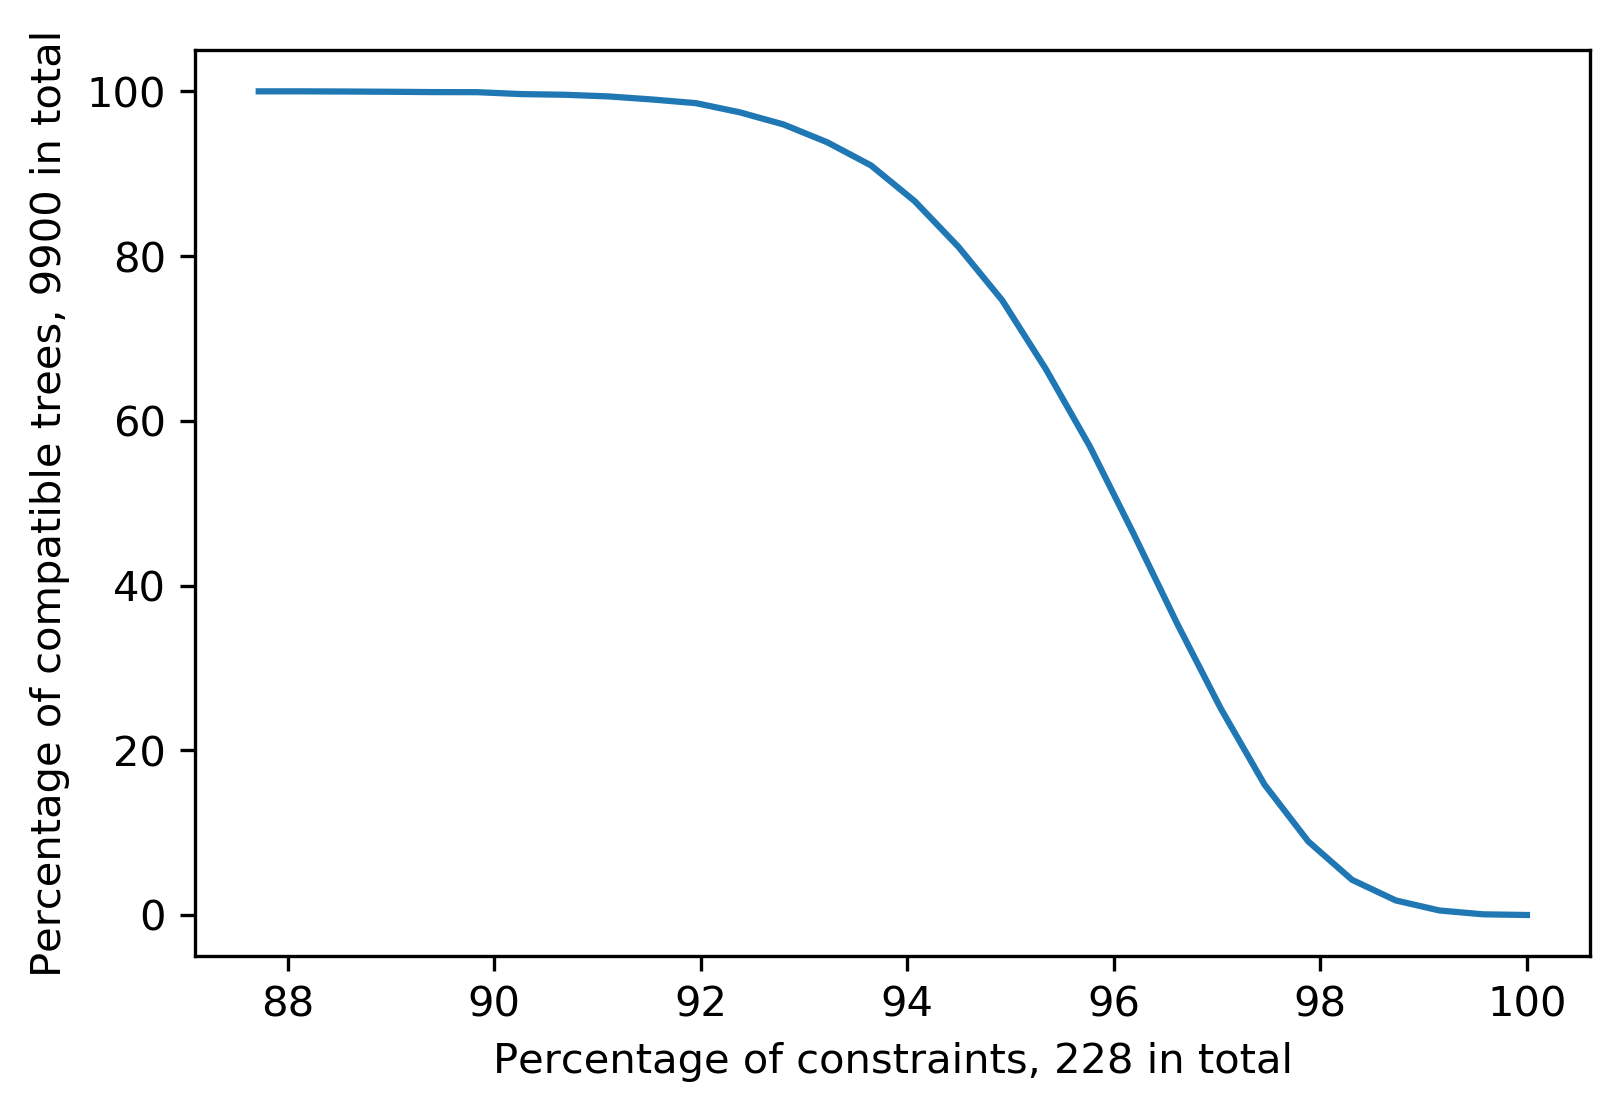

In [667]:
fig, ax = plt.subplots(dpi=300)
ax.set_xlabel('Percentage of constraints, %i in total' % num_constraints)
ax.set_ylabel('Percentage of compatible trees, %i in total' % num_trees)
ax.plot((x/num_constraints)*100,
        y*100);

In [824]:
cluster0_coords = cluster_coords.loc[cluster0].copy()
cluster0_coords.sort_values(by='constraint_distance', ascending=False, inplace=True)

In [822]:
cluster0_coords.iloc[:5]

,x,y,cluster,cluster_size,compatibility_count,constraint_support,constraint_distance
"(n153, n43)",-0.074736,-0.266254,0,228,9656,1,2.421620
"(n114, n168)",-0.083202,-0.267861,0,228,9733,1,2.336984
"(n137, n43)",-0.089754,-0.317725,0,228,9261,3,2.321203
"(n77, n168)",-0.069981,-0.292699,0,228,9548,1,2.002586
"(n144, n113)",-0.083164,-0.277383,0,228,9900,1,1.997479


In [823]:
cluster0_coords.iloc[-5:]

,x,y,cluster,cluster_size,compatibility_count,constraint_support,constraint_distance
"(n96, n77)",-0.065871,-0.289165,0,228,9560,1,0.124887
"(n81, n71)",-0.026797,-0.252330,0,228,8984,1,0.122510
"(n70, n47)",-0.107211,-0.300421,0,228,9365,1,0.115212
"(n81, n75)",-0.074735,-0.252804,0,228,9464,1,0.101823
"(n165, n168)",-0.095277,-0.163030,0,228,8219,20,0.096659


In [458]:
mt_black = set()
mt_green = set()
for line in open('maxtic.input_MT_output_partial_order').readlines():
    line = line.split()
    if line[-1] == 'black':
        mt_black.add((line[0], line[1]))
    else:
        mt_green.add((line[0], line[1]))
mt = mt_black.union(mt_green)

cluster0 = set(cluster_coords.query('cluster==0').index.tolist())
cluster1 = set(cluster_coords.query('cluster==1').index.tolist())

In [463]:
print('MaxTic VS this thing we are doing: %.4f' % 
      (len(mt.intersection(cluster0))/len(mt.union(cluster0)))
     )
print('MaxTic BLACK VS this thing we are doing: %.4f' % 
      (len(mt_black.intersection(cluster0))/len(mt_black.union(cluster0)))
     )
print('MaxTic GREEN VS this thing we are doing: %.4f' % 
      (len(mt_green.intersection(cluster0))/len(mt_green.union(cluster0)))
     )

MaxTic VS this thing we are doing: 0.4962
MaxTic BLACK VS this thing we are doing: 0.5637
MaxTic GREEN VS this thing we are doing: 0.0643


In [464]:
print('MaxTic VS this thing we are doing (weaker signal): %.4f' % 
      (len(mt.intersection(cluster1))/len(mt.union(cluster1)))
     )
print('MaxTic BLACK VS this thing we are doing (weaker signal): %.4f' % 
      (len(mt_black.intersection(cluster1))/len(mt_black.union(cluster1)))
     )
print('MaxTic GREEN VS this thing we are doing (weaker signal): %.4f' % 
      (len(mt_green.intersection(cluster1))/len(mt_green.union(cluster1)))
     )

MaxTic VS this thing we are doing (weaker signal): 0.3149
MaxTic BLACK VS this thing we are doing (weaker signal): 0.2010
MaxTic GREEN VS this thing we are doing (weaker signal): 0.2222
